Research question:
What is the forecast for airpoulltion in Kathmandy valley?

Type of analysis:
Predictive Analysis: How much airpollution can be expected to rise in upcoming years and when?

Possible stakeholders:
1.Health sector: Hospitals and clinics can anticipate surges in respiratory or cardiovascular cases during bad air days, and prepare resources.
2.Tourism Industry: Cleaner air initiatives can attract eco-tourists and improve Nepal’s image as a trekking/cultural destination.
3.Public : Can prepare for bad airdays based on predictions

KPIs to focus on:
1.Actionable Insights Generated
2.Health/Environmental Impact
3.Insight KPI 

Scope and limitations:
1.Focus Area
Study of air quality (e.g., PM2.5, PM10, NO₂) in Kathmandu Valley.

Prediction of air quality in the future.

2.Data Sources

Secondary datasets: Fill later

Hospital admission records or public health data (if accessible) : Fill later

Supplementary data: Fill later

3.Geographical Coverage
Kathmandu Metropolitan Area

4.Deliverables
Analytical report with insights.

Visualizations (graphs showing AQI vs. health trends).

Predictions

Recommendations for individuals, policymakers, or businesses.


Limitations:
1.Geographical Limitations

Restricted to Kathmandu Valley; results may not generalize to all of Nepal.

2.Accuracy

How accurate the predictions will be remains to be seen 


Data collection and aquisition
1.Dataset type : CSV format imported to SQL
2.Data source: Air quality index in Kathmandu US Diplomatic Post Phora Durbar by American Embassey (Open data Nepal)
3.Format : CSV

# Importing data

In [2]:
import pandas as pd
import numpy as np

In [54]:
import pyodbc as pyodbc
conn = pyodbc.connect('Driver={SQL Server};server=LAPTOP-7UQ473VF;DATABASE=AIRQUALITY;TRUSTED_CONNECTION=YES;')
df2 = pd.read_sql("SELECT * FROM AQTable", conn) 

C:\Users\USER\AppData\Local\Temp\ipykernel_24644\1042391439.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df2 = pd.read_sql("SELECT * FROM AQTable", conn)


# Basic EDA and data extraction

In [55]:
df2.head()

,locationId,location,city,country,utc,local,parameter,value,unit,latitude,longitude
0,3460,US Diplomatic Post: Phora Durbar Kathmandu,Kathmandu,NP,2021-03-12T18:15:00+00:00,2021-03-13T00:00:00+05:45,o3,0.051,ppm,27.712463,85.315704
1,3460,US Diplomatic Post: Phora Durbar Kathmandu,Kathmandu,NP,2021-03-12T18:15:00+00:00,2021-03-13T00:00:00+05:45,pm25,69.000,┬╡g/m┬│,27.712463,85.315704
2,3460,US Diplomatic Post: Phora Durbar Kathmandu,Kathmandu,NP,2021-03-12T17:15:00+00:00,2021-03-12T23:00:00+05:45,pm25,69.000,┬╡g/m┬│,27.712463,85.315704
3,3460,US Diplomatic Post: Phora Durbar Kathmandu,Kathmandu,NP,2021-03-12T17:15:00+00:00,2021-03-12T23:00:00+05:45,o3,0.030,ppm,27.712463,85.315704
4,3460,US Diplomatic Post: Phora Durbar Kathmandu,Kathmandu,NP,2021-03-12T16:15:00+00:00,2021-03-12T22:00:00+05:45,o3,0.030,ppm,27.712463,85.315704


In [56]:
df2.describe()

,locationId,value,latitude,longitude
count,61976.0,61976.000000,6.197600e+04,6.197600e+04
mean,3460.0,-13.381631,2.771246e+01,8.531570e+01
std,0.0,202.677872,1.065823e-14,2.842194e-14
min,3460.0,-999.000000,2.771246e+01,8.531570e+01
25%,3460.0,0.012000,2.771246e+01,8.531570e+01
50%,3460.0,0.060000,2.771246e+01,8.531570e+01
75%,3460.0,37.000000,2.771246e+01,8.531570e+01
max,3460.0,985.000000,2.771246e+01,8.531570e+01


In [57]:
df2.isna().sum()

locationId    0
location      0
city          0
country       0
utc           0
local         0
parameter     0
value         0
unit          0
latitude      0
longitude     0
dtype: int64

In [58]:
df2.duplicated().any()

np.False_

In [59]:
df2.isnull().sum()

locationId    0
location      0
city          0
country       0
utc           0
local         0
parameter     0
value         0
unit          0
latitude      0
longitude     0
dtype: int64

##### Data extraction:
Extracting only necessary columns from dataset here in this case pm25 values and timestamps

In [60]:
targetDF = df2[['local','parameter','value']].where(df2['parameter']=='pm25').dropna()

Using local(timestamps) as index and ensuring chronological order

In [61]:
targetDF['local'] = pd.to_datetime(targetDF['local'])

In [62]:
targetDF = targetDF.set_index('local').sort_index()

Plotting data to check for erronous data

In [63]:
import matplotlib.pyplot as plt

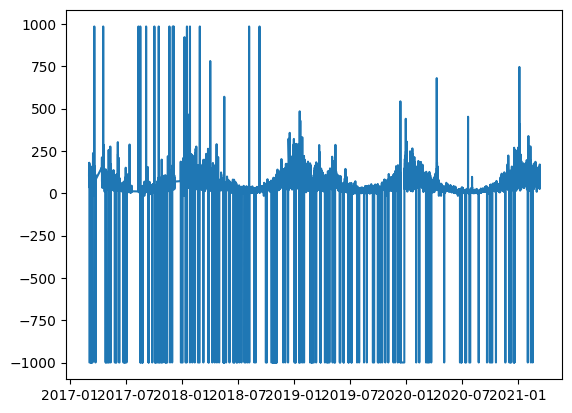

In [65]:
x = targetDF.index
y = targetDF['value']
fig, ax = plt.subplots()
ax.plot(x, y)
plt.show()

Checking if the peaks are sensor error or practical data

In [66]:
anomalies = targetDF[targetDF['value']>500]


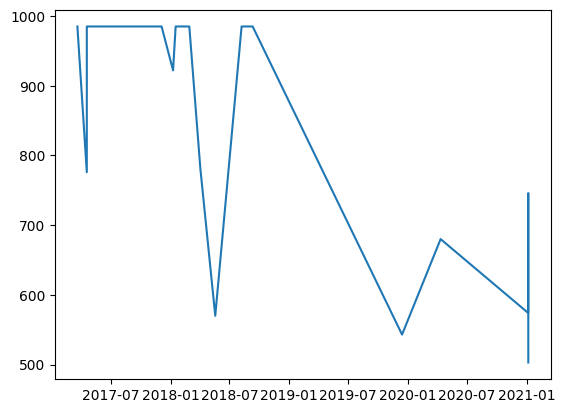

In [68]:
import matplotlib.pyplot as plt
x = anomalies.index
y = anomalies['value']
fig, ax = plt.subplots()
ax.plot(x, y)


#### Conclusions from basic EDA:
Below 0 values and above 500 values(spikes) are erronous data from sensors so needs to be cleaned

# Basic Data Cleaning

Replacing values less than 0 as NAN and interpolating

In [69]:
#condition = targetDF['value'] < 0 (Completely messes the time series so not used)
#targetDF2 = targetDF[~condition]
targetDF['value'] = targetDF['value'].mask(targetDF['value'] < 0, pd.NA)
targetDF['value'] = targetDF['value'].interpolate(method='linear',limit_direction='both')

Similarly removing values above 500 as NAN and interpolating them

<Axes: title={'center': 'Cleaned data'}, xlabel='local'>

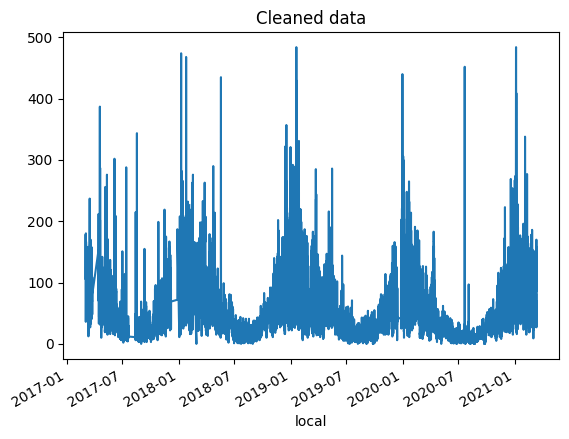

In [70]:
import numpy as np
targetDF.loc[targetDF['value']>500,'value'] = np.nan
targetDF['value'] = targetDF['value'].interpolate(method='linear', limit_direction='both')
targetDF['value'].plot(title='Cleaned data')


# Advanced EDA 

#### Seasonal, monthly and daily trend plots

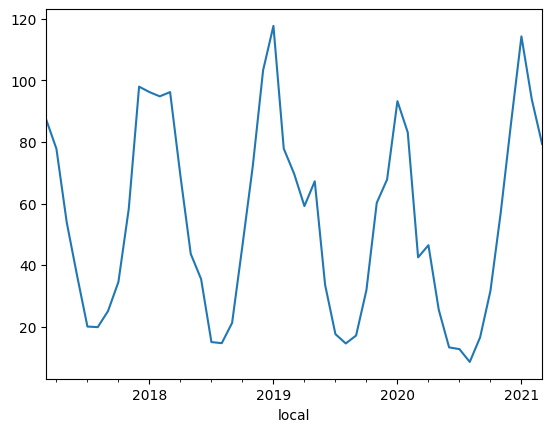

In [72]:
targetDF['value'].resample('ME').mean().plot()
plt.show()

For seasonal visualization extracting the sesason based on months value

In [74]:
def get_season(month) :
    if month in [3,4]:
        return 'spring'
    if month in [5,6]:
        return 'summer'
    if month in [7,8,9]:
        return 'monsoon'
    if month in [10,11]:
        return 'autumn'
    else:
        return 'winter'
targetDF['season'] = targetDF.index.month.map(get_season)     


<Axes: xlabel='month'>

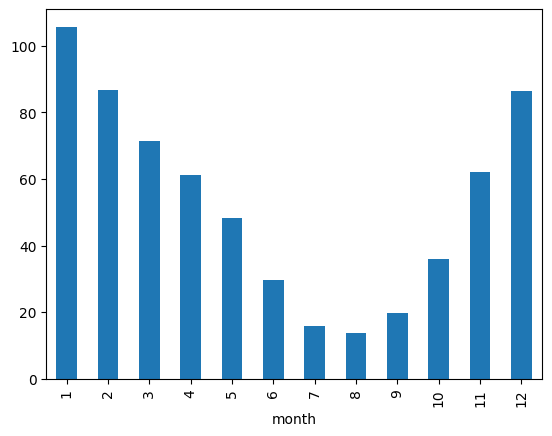

In [75]:
targetDF['month'] = targetDF.index.month
targetDF.groupby('month')['value'].mean().plot(kind='bar')

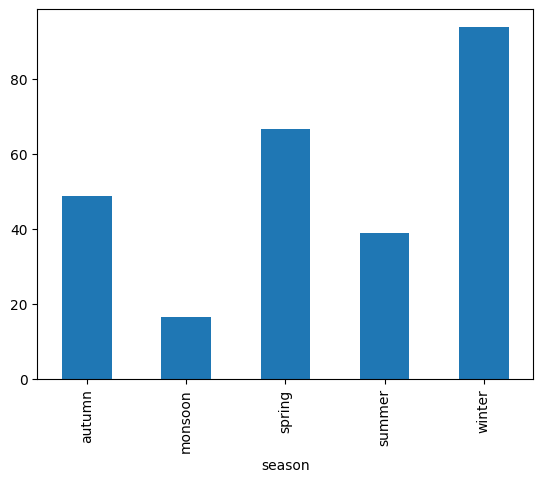

In [76]:
targetDF.groupby('season')['value'].mean().plot(kind='bar')
plt.show()

In [77]:
targetDF['hour'] = targetDF.index.hour

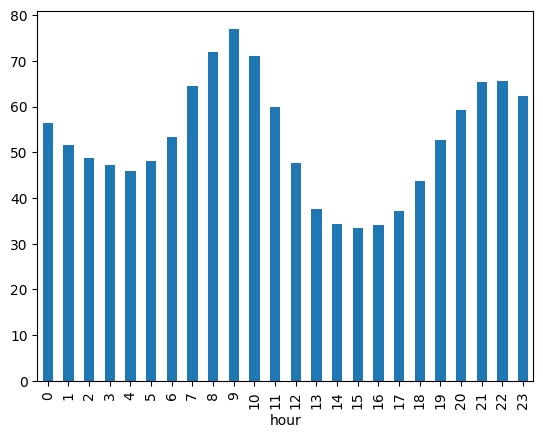

In [78]:
targetDF.groupby('hour')['value'].mean().plot(kind='bar')
plt.show()

In [79]:
from statsmodels.graphics.tsaplots import plot_acf

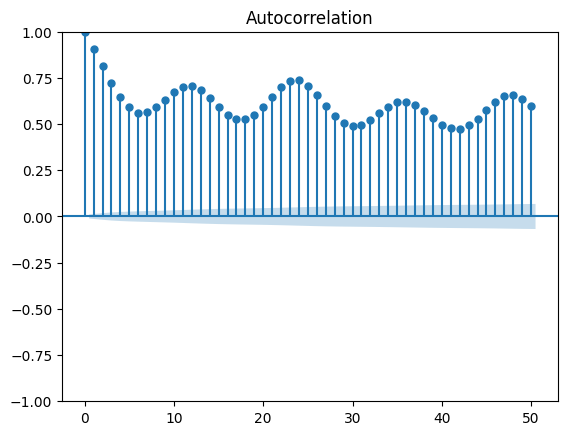

In [80]:
plot_acf(targetDF['value'], lags=50)   
plt.show()

#### Seasonal trend decomposition

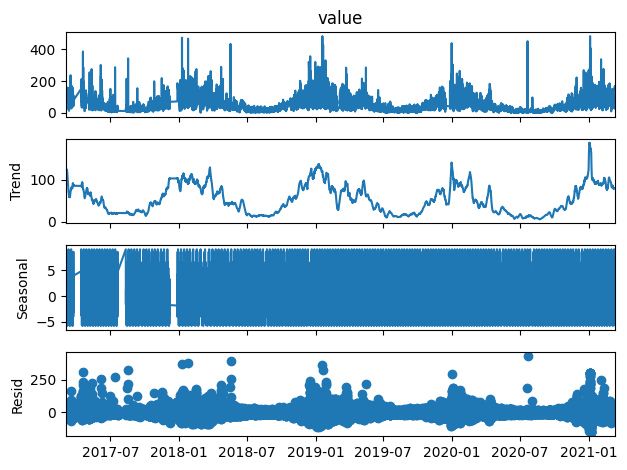

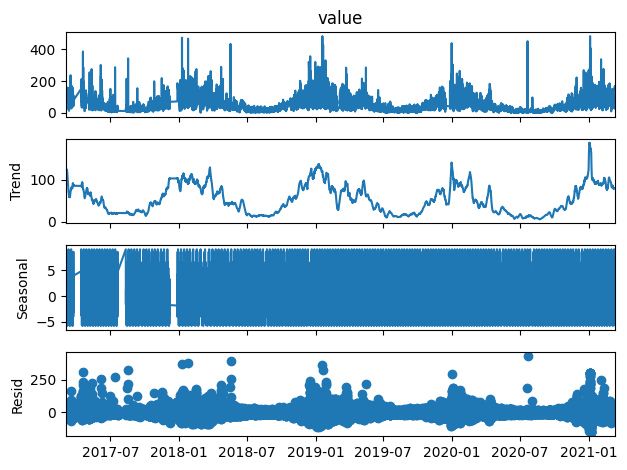

In [81]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(targetDF['value'], model='additive', period=168)
result.plot()

##### Conclusions from advanced EDA
1. Yearly seasonal trend : Pm25 value peaks during winter and is minimum during monsoon. The airpoulltion pm24 level is of the following order:
  winter>spring>summer>monsoon
2. Pollution level peaks in January wheres the pollution level is minimum in the month of July decreasing gradually and then increasing till december
3. Pollution pm25 level peaks during early office hours maybe due to increased traffic around 9:00 am then is minimum during the day as the sun heats the air and disperses pollutants.
4. During evening 5:00pm air starts cooling and thus pollution level starts increasing
5. Pm25 has clear daily and seasonal trends.

This shows it is suitable for SARIMA model as it follows its requirement as it is stationary